In [1]:
import matplotlib.pyplot as plt

import glob, os, itertools
from pathlib import Path

from regions import PointSkyRegion, CircleSkyRegion

import numpy as np

import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.time import Time
from astropy.table import Table

from gammapy.data import DataStore, Observation, observatory_locations, EventList
from gammapy.datasets import (
    MapDataset,
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.estimators import ASmoothMapEstimator, TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators.utils import resample_energy_edges, find_peaks, find_peaks_in_flux_map
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import (
    MapDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    FoVBackgroundMaker
)
from gammapy.maps import MapAxis, RegionGeom, RegionNDMap, WcsGeom, Map, TimeMapAxis
from gammapy.modeling.models import (
    PowerLawNormSpectralModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel
)

import warnings

In [2]:
input_filenames = []
input_filenames.append(glob.glob(os.path.join("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/UFO/Experiment/", '*.fits')))
input_filenames = tuple(itertools.chain.from_iterable(input_filenames))

datastore = DataStore.from_events_files(np.sort(input_filenames), 
                                        irfs_paths="/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits")
datastore.hdu_table.write("hdu-index.fits.gz", overwrite=True)
datastore.obs_table.write("obs-index.fits.gz", overwrite=True)

datastore.obs_table

OBS_ID,TSTART,TSTOP,ONTIME,LIVETIME,DEADC,TELESCOP,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,OBJECT,EVENTS_FILENAME,EVENT_COUNT,CALDB,IRF,IRF_FILENAME,MJDREFI,MJDREFF,TIMEUNIT,TIMESYS,TIMEREF
,s,s,s,s,,,deg,deg,deg,deg,,,,,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,str3,float64,float64,float64,float64,str13,str13,str13,str13,str1,str8,str89,int64,str13,str13,str189,int64,float64,str1,str2,str5
0,7171.200000000006,14371.2,7199.999999999994,7199.999999999994,1.0,CTA,40.669,0.4869999999999999,171.56100364863156,-51.56311119787755,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,,NGC_1068,/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/UFO/Experiment/events_obs0.fits,97330,NOT AVAILABLE,NOT AVAILABLE,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits,61188,0.000800740737759042,s,tt,LOCAL
1,14135.606557377052,21335.606557377054,7200.000000000004,7200.000000000004,1.0,CTA,41.16900001286943,-0.0129995049998257,172.69766568256216,-51.595774065143495,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,,NGC_1068,/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/UFO/Experiment/events_obs1.fits,93415,NOT AVAILABLE,NOT AVAILABLE,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits,61188,0.000800740737759042,s,tt,LOCAL
10,76815.26557377048,84015.26557377049,7200.000000000004,7200.000000000004,1.0,CTA,40.669,-0.513,172.65327684026465,-52.30234689412969,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,,NGC_1068,/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/UFO/Experiment/events_obs10.fits,96636,NOT AVAILABLE,NOT AVAILABLE,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits,61188,0.000800740737759042,s,tt,LOCAL
11,83779.67213114754,90979.67213114753,7199.999999999994,7199.999999999994,1.0,CTA,40.16899998713056,-0.01299950499982582,171.49862014667832,-52.26916581926981,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,,NGC_1068,/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/UFO/Experiment/events_obs11.fits,98907,NOT AVAILABLE,NOT AVAILABLE,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits,61188,0.000800740737759042,s,tt,LOCAL
12,90744.0786885246,97944.07868852458,7199.999999999994,7199.999999999994,1.0,CTA,40.669,0.4869999999999999,171.56100364863156,-51.56311119787755,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,,NGC_1068,/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/UFO/Experiment/events_obs12.fits,96853,NOT AVAILABLE,NOT AVAILABLE,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits,61188,0.000800740737759042,s,tt,LOCAL
13,97708.48524590163,104908.48524590164,7199.999999999994,7199.999999999994,1.0,CTA,41.16900001286943,-0.0129995049998257,172.69766568256216,-51.595774065143495,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,,NGC_1068,/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/UFO/Experiment/events_obs13.fits,93390,NOT AVAILABLE,NOT AVAILABLE,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits,61188,0.000800740737759042,s,tt,LOCAL
14,104672.89180327869,111872.8918032787,7199.999999999994,7199.999999999994,1.0,CTA,40.669,-0.513,172.65327684026465,-52.30234689412969,NOT AVAILABLE

In [3]:
datastore.hdu_table

HDU_TYPE,HDU_CLASS,HDU_NAME,OBS_ID,FILE_DIR,FILE_NAME
str6,str10,str21,int64,str131,str57
events,events,EVENTS,0,/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/UFO/Experiment,events_obs0.fits
gti,gti,GTI,0,/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/UFO/Experiment,events_obs0.fits
aeff,aeff_2d,EFFECTIVE AREA,0,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS,Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits
edisp,edisp_2d,ENERGY DISPERSION,0,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS,Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits
psf,psf_3gauss,POINT SPREAD FUNCTION,0,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS,Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits
bkg,bkg_3d,BACKGROUND,0,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS,Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits
events,events,EVENTS,1,/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/UFO/Experiment,events_obs1.fits
gti,gti,GTI,1,/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/UFO/Experiment,events_obs1.fits
aeff,aeff_2d,EFFECTIVE AREA,1,/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS,Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits


In [4]:
print(f"The mean exposure of the runs is {np.mean(datastore.obs_table['LIVETIME']) * u.s}\n")
print(f"The total exposure time is {(np.sum(datastore.obs_table['LIVETIME']) * u.s).to('hr')}\n")
print(f"These are the selected runs: \n {datastore.obs_table['OBS_ID']}")

The mean exposure of the runs is 7199.999999999999 s

The total exposure time is 123.99999999999999 h

These are the selected runs: 
 OBS_ID
------
     0
     1
    10
    11
    12
    13
    14
    15
    16
    17
   ...
    56
    57
    58
    59
     6
    60
    61
     7
     8
     9
Length = 62 rows


In [5]:
observations = datastore.get_observations(obs_id=list(datastore.obs_table['OBS_ID']))

# let's find the highest quality run:
longest_obs = np.zeros((len(observations)), float)
for i,obs in enumerate(observations):
    longest_obs[i] = len(obs.events.table)
print(f"The run with the highest counting statistics is observation #{int(np.argmax(longest_obs))}," + 
      f"i.e. ObsID {observations[int(np.argmax(longest_obs))].obs_id}")

The run with the highest counting statistics is observation #42,i.e. ObsID 47


In [6]:
# let's inspect the GTI
observations[int(np.argmax(longest_obs))].gti

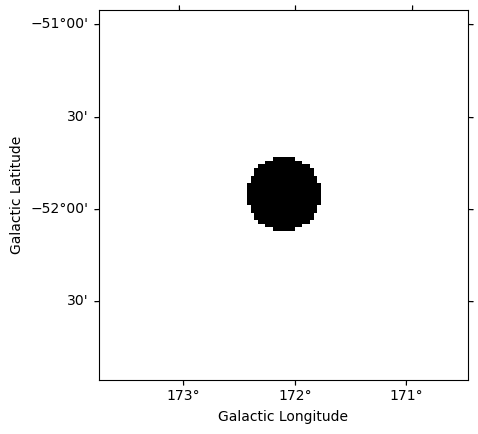

In [7]:
bkg = "FoV"

# we consider a square map of size 2.0 deg, spatially binned with bins of 0.02 deg:
# we define the ON region, assuming a circle of 0.3 deg of radius, for the source:
width = 2    #deg
binsz = 0.02 #deg 
radius= 0.2  #deg

target_position = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")
on_region_radius = Angle(radius * u.deg)
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

npix = int(width/binsz)

# let's define an exclusion region, in order to better estimate the bkg:
exclusion_region = CircleSkyRegion(
    center=target_position,
    radius=radius * u.deg,
)

geom_excl = WcsGeom.create(
    npix=(npix, npix), binsz=binsz, skydir=target_position.galactic, proj="TAN", frame="galactic"
    #npix=(npix, npix), binsz=binsz, skydir=w1.galactic, proj="TAN", frame="galactic"
)

exclusion_mask = ~geom_excl.region_mask([exclusion_region])
exclusion_mask.plot()
plt.show()

In [8]:
# Create the reconstruced energy range:
e_min, e_max = 0.1 * u.TeV, 100 * u.TeV
energy_axis = MapAxis.from_energy_bounds(
    e_min, e_max, nbin=10, per_decade=True, unit="TeV", name="energy"
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.01, 300, nbin=10, per_decade=True, unit="TeV", name="energy_true"
)

if bkg == "FoV":
    geom = WcsGeom.create(
        skydir=(target_position.galactic.l.deg , target_position.galactic.b.deg),
        binsz=binsz,
        width=(width, width),
        frame="galactic",
        proj="CAR",
        axes=[energy_axis],
    )

    stacked = MapDataset.create(
        geom=geom, energy_axis_true=energy_axis_true, name="my-dataset"
    )

    dataset_maker = MapDatasetMaker()
    
    maker_fov = FoVBackgroundMaker(method="scale", 
                                   exclusion_mask=exclusion_mask,
                                   )
    
# let's impone a safe range for the analysis: we consider only events at a distance from the pointing direction < 3 deg.
offset_max = 3 * u.deg
safe_mask_masker = SafeMaskMaker(
    methods=["aeff-default"], offset_max=offset_max
#    methods=["offset-max", "aeff-default"], offset_max=offset_max
#    methods=["offset-max", "aeff-max"], offset_max=offset_max, aeff_percent=10
)

# let's create the dataset for each observation and stack them all:
for i, observation in enumerate(observations):
    if bkg == "FoV":
        dataset = dataset_maker.run(stacked.copy(name=str(observation.obs_id)), observation)
        
        # A MapDataset is filled in this cutout geometry
        dataset = safe_mask_masker.run(dataset, observation)
        dataset = maker_fov.run(dataset)
        
        # The data quality cut is applied
        stacked.stack(dataset)
        
        print(f"{i+1} of {len(observations)}, Background norm obs {observation.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}")

No default upper safe energy threshold defined for obs 0
No default lower safe energy threshold defined for obs 0


1 of 62, Background norm obs 0: 1.00


No default upper safe energy threshold defined for obs 1
No default lower safe energy threshold defined for obs 1


2 of 62, Background norm obs 1: 0.99


No default upper safe energy threshold defined for obs 10
No default lower safe energy threshold defined for obs 10


3 of 62, Background norm obs 10: 1.00


No default upper safe energy threshold defined for obs 11
No default lower safe energy threshold defined for obs 11


4 of 62, Background norm obs 11: 1.00


No default upper safe energy threshold defined for obs 12
No default lower safe energy threshold defined for obs 12


5 of 62, Background norm obs 12: 1.00


No default upper safe energy threshold defined for obs 13
No default lower safe energy threshold defined for obs 13


6 of 62, Background norm obs 13: 1.00


No default upper safe energy threshold defined for obs 14
No default lower safe energy threshold defined for obs 14


7 of 62, Background norm obs 14: 1.01


No default upper safe energy threshold defined for obs 15
No default lower safe energy threshold defined for obs 15


8 of 62, Background norm obs 15: 1.00


No default upper safe energy threshold defined for obs 16
No default lower safe energy threshold defined for obs 16


9 of 62, Background norm obs 16: 1.00


No default upper safe energy threshold defined for obs 17
No default lower safe energy threshold defined for obs 17


10 of 62, Background norm obs 17: 1.00


No default upper safe energy threshold defined for obs 18
No default lower safe energy threshold defined for obs 18


11 of 62, Background norm obs 18: 1.00


No default upper safe energy threshold defined for obs 19
No default lower safe energy threshold defined for obs 19


12 of 62, Background norm obs 19: 0.99


No default upper safe energy threshold defined for obs 2
No default lower safe energy threshold defined for obs 2


13 of 62, Background norm obs 2: 1.01


No default upper safe energy threshold defined for obs 20
No default lower safe energy threshold defined for obs 20


14 of 62, Background norm obs 20: 1.00


No default upper safe energy threshold defined for obs 21
No default lower safe energy threshold defined for obs 21


15 of 62, Background norm obs 21: 1.01


No default upper safe energy threshold defined for obs 22
No default lower safe energy threshold defined for obs 22


16 of 62, Background norm obs 22: 1.00


No default upper safe energy threshold defined for obs 23
No default lower safe energy threshold defined for obs 23


17 of 62, Background norm obs 23: 0.99


No default upper safe energy threshold defined for obs 24
No default lower safe energy threshold defined for obs 24


18 of 62, Background norm obs 24: 1.00


No default upper safe energy threshold defined for obs 25
No default lower safe energy threshold defined for obs 25


19 of 62, Background norm obs 25: 1.02


No default upper safe energy threshold defined for obs 26
No default lower safe energy threshold defined for obs 26


20 of 62, Background norm obs 26: 0.99


No default upper safe energy threshold defined for obs 27
No default lower safe energy threshold defined for obs 27


21 of 62, Background norm obs 27: 1.01


No default upper safe energy threshold defined for obs 28
No default lower safe energy threshold defined for obs 28


22 of 62, Background norm obs 28: 1.00


No default upper safe energy threshold defined for obs 29
No default lower safe energy threshold defined for obs 29


23 of 62, Background norm obs 29: 0.99


No default upper safe energy threshold defined for obs 3
No default lower safe energy threshold defined for obs 3


24 of 62, Background norm obs 3: 1.00


No default upper safe energy threshold defined for obs 30
No default lower safe energy threshold defined for obs 30


25 of 62, Background norm obs 30: 1.00


No default upper safe energy threshold defined for obs 31
No default lower safe energy threshold defined for obs 31


26 of 62, Background norm obs 31: 1.00


No default upper safe energy threshold defined for obs 32
No default lower safe energy threshold defined for obs 32


27 of 62, Background norm obs 32: 0.99


No default upper safe energy threshold defined for obs 33
No default lower safe energy threshold defined for obs 33


28 of 62, Background norm obs 33: 0.98


No default upper safe energy threshold defined for obs 34
No default lower safe energy threshold defined for obs 34


29 of 62, Background norm obs 34: 1.00


No default upper safe energy threshold defined for obs 35
No default lower safe energy threshold defined for obs 35


30 of 62, Background norm obs 35: 0.99


No default upper safe energy threshold defined for obs 36
No default lower safe energy threshold defined for obs 36


31 of 62, Background norm obs 36: 0.99


No default upper safe energy threshold defined for obs 37
No default lower safe energy threshold defined for obs 37


32 of 62, Background norm obs 37: 0.99


No default upper safe energy threshold defined for obs 38
No default lower safe energy threshold defined for obs 38


33 of 62, Background norm obs 38: 0.99


No default upper safe energy threshold defined for obs 39
No default lower safe energy threshold defined for obs 39


34 of 62, Background norm obs 39: 1.01


No default upper safe energy threshold defined for obs 4
No default lower safe energy threshold defined for obs 4


35 of 62, Background norm obs 4: 1.00


No default upper safe energy threshold defined for obs 40
No default lower safe energy threshold defined for obs 40


36 of 62, Background norm obs 40: 1.00


No default upper safe energy threshold defined for obs 41
No default lower safe energy threshold defined for obs 41


37 of 62, Background norm obs 41: 1.00


No default upper safe energy threshold defined for obs 42
No default lower safe energy threshold defined for obs 42


38 of 62, Background norm obs 42: 1.00


No default upper safe energy threshold defined for obs 43
No default lower safe energy threshold defined for obs 43


39 of 62, Background norm obs 43: 1.00


No default upper safe energy threshold defined for obs 44
No default lower safe energy threshold defined for obs 44


40 of 62, Background norm obs 44: 1.00


No default upper safe energy threshold defined for obs 45
No default lower safe energy threshold defined for obs 45


41 of 62, Background norm obs 45: 1.00


No default upper safe energy threshold defined for obs 46
No default lower safe energy threshold defined for obs 46


42 of 62, Background norm obs 46: 1.00


No default upper safe energy threshold defined for obs 47
No default lower safe energy threshold defined for obs 47


43 of 62, Background norm obs 47: 1.01


No default upper safe energy threshold defined for obs 48
No default lower safe energy threshold defined for obs 48


44 of 62, Background norm obs 48: 1.00


No default upper safe energy threshold defined for obs 49
No default lower safe energy threshold defined for obs 49


45 of 62, Background norm obs 49: 0.99


No default upper safe energy threshold defined for obs 5
No default lower safe energy threshold defined for obs 5


46 of 62, Background norm obs 5: 1.00


No default upper safe energy threshold defined for obs 50
No default lower safe energy threshold defined for obs 50


47 of 62, Background norm obs 50: 1.00


No default upper safe energy threshold defined for obs 51
No default lower safe energy threshold defined for obs 51


48 of 62, Background norm obs 51: 0.99


No default upper safe energy threshold defined for obs 52
No default lower safe energy threshold defined for obs 52


49 of 62, Background norm obs 52: 1.00


No default upper safe energy threshold defined for obs 53
No default lower safe energy threshold defined for obs 53


50 of 62, Background norm obs 53: 1.01


No default upper safe energy threshold defined for obs 54
No default lower safe energy threshold defined for obs 54


51 of 62, Background norm obs 54: 1.00


No default upper safe energy threshold defined for obs 55
No default lower safe energy threshold defined for obs 55


52 of 62, Background norm obs 55: 1.00


No default upper safe energy threshold defined for obs 56
No default lower safe energy threshold defined for obs 56


53 of 62, Background norm obs 56: 0.99


No default upper safe energy threshold defined for obs 57
No default lower safe energy threshold defined for obs 57


54 of 62, Background norm obs 57: 1.01


No default upper safe energy threshold defined for obs 58
No default lower safe energy threshold defined for obs 58


55 of 62, Background norm obs 58: 1.00


No default upper safe energy threshold defined for obs 59
No default lower safe energy threshold defined for obs 59


56 of 62, Background norm obs 59: 1.00


No default upper safe energy threshold defined for obs 6
No default lower safe energy threshold defined for obs 6


57 of 62, Background norm obs 6: 1.00


No default upper safe energy threshold defined for obs 60
No default lower safe energy threshold defined for obs 60


58 of 62, Background norm obs 60: 1.00


No default upper safe energy threshold defined for obs 61
No default lower safe energy threshold defined for obs 61


59 of 62, Background norm obs 61: 1.00


No default upper safe energy threshold defined for obs 7
No default lower safe energy threshold defined for obs 7


60 of 62, Background norm obs 7: 1.00


No default upper safe energy threshold defined for obs 8
No default lower safe energy threshold defined for obs 8


61 of 62, Background norm obs 8: 1.00


No default upper safe energy threshold defined for obs 9
No default lower safe energy threshold defined for obs 9


62 of 62, Background norm obs 9: 1.00


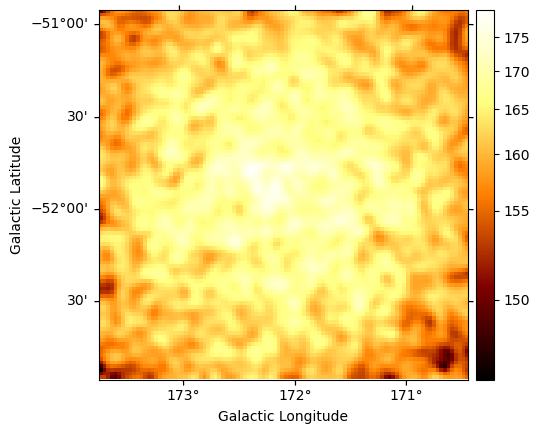

In [9]:
# plot the counts map
if bkg == "FoV":
    stacked.counts.sum_over_axes().smooth(0.03 * u.deg).plot(stretch="sqrt", add_cbar=True)
plt.show()

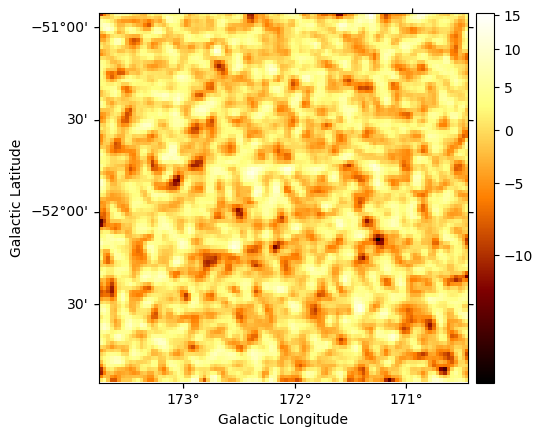

In [10]:
# plot the excess map
excess = stacked.excess.sum_over_axes()
excess.smooth("0.02 deg").plot(stretch="sqrt", add_cbar=True)
plt.show()

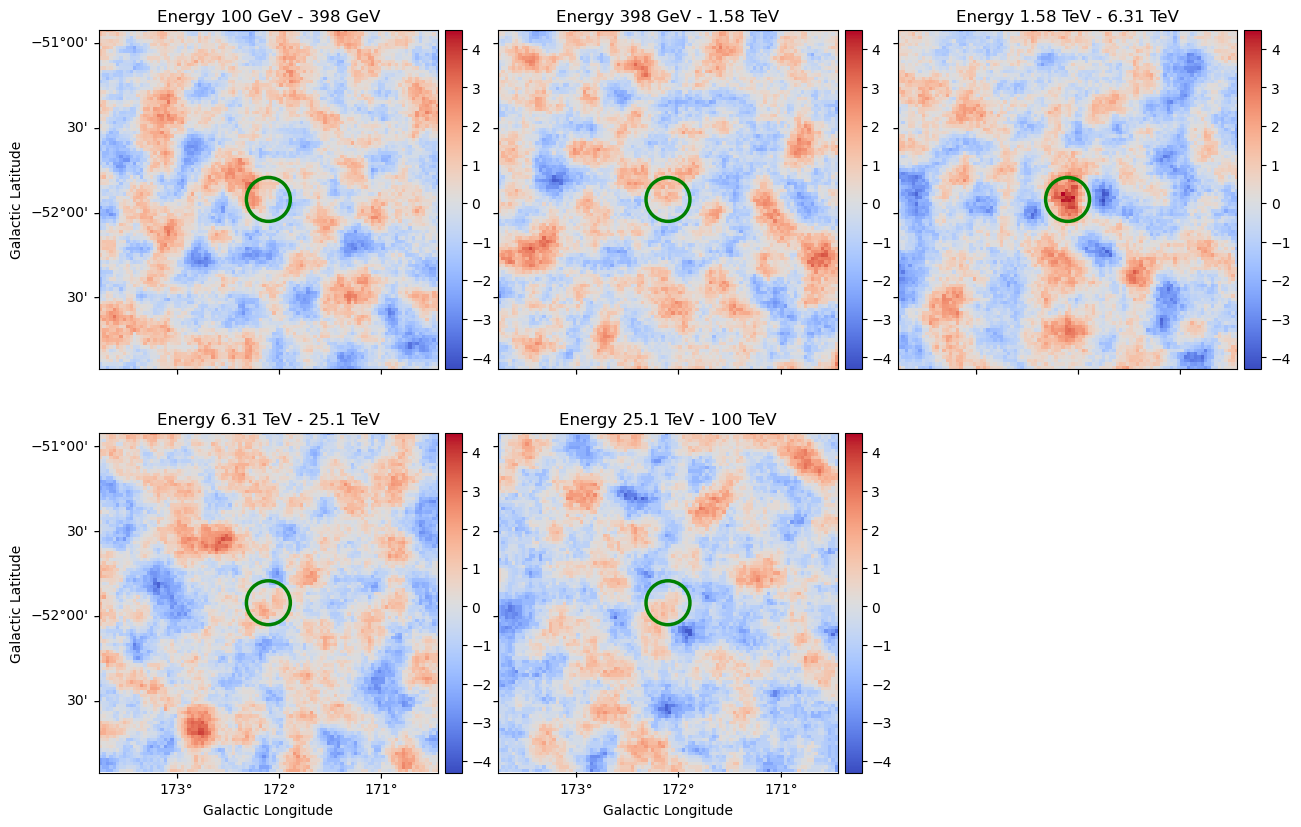

In [11]:
# let's consider more than one energy bin and a correlation radius of 0.1 deg
estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional="all",
    #energy_edges=[0.5, 2, 5, 10, 30, 100] * u.TeV,
    energy_edges=energy_axis.downsample(6).edges,
)

result = estimator.run(stacked)
ax = result["sqrt_ts"].plot_grid(
    figsize=(15, 10), cmap="coolwarm", add_cbar=True, 
    vmin=np.min(result["sqrt_ts"].data[~np.isnan(result["sqrt_ts"].data)]), 
    vmax=np.max(result["sqrt_ts"].data[~np.isnan(result["sqrt_ts"].data)]), 
    ncols=3)

for p in ax.reshape(ax.size):
    p.scatter(
        target_position.galactic.l.deg, target_position.galactic.b.deg,
        transform=p.get_transform("galactic"),
        color="None", edgecolor="g", marker="o",
        s=1000, lw=2.5,
    )

plt.show()

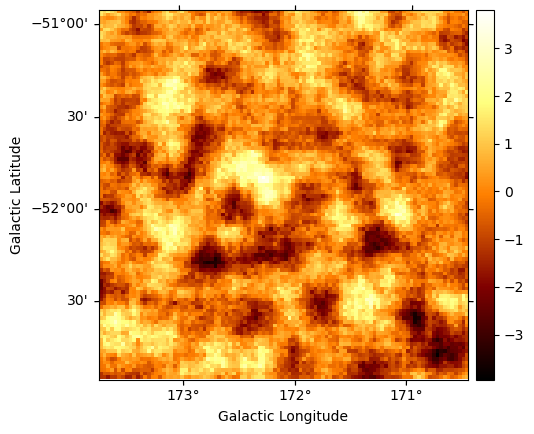

In [12]:
excess_estimator_integrated = ExcessMapEstimator(
    correlation_radius="0.1 deg", selection_optional="all", n_sigma=1,
    n_sigma_ul=3,
    energy_edges=[0.1, 100] * u.TeV,
    correlate_off=True
)
excess_integrated = excess_estimator_integrated.run(stacked)

excess_integrated["sqrt_ts"].plot(add_cbar=True)
plt.show()

<Table length=0>
<No columns>

KeyError: 'ra'

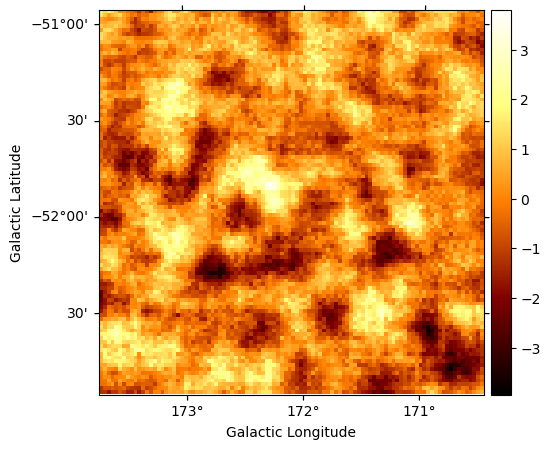

In [13]:
# set a threshold of detection at 4 sigma and a minimum distance amongst detected source of 0.2 deg:
sources = find_peaks(excess_integrated["sqrt_ts"], threshold=5., min_distance="0.2 deg")
nsou = len(sources)
display(sources)

# Plot sources on top of significance sky image
plt.figure(figsize=(9, 5))
ax = excess_integrated["sqrt_ts"].plot(add_cbar=True)

ax.scatter(
    sources["ra"], sources["dec"],
    transform=ax.get_transform("icrs"),
    color="None", edgecolor="b", marker="o",
    s=600, lw=1.5,
)
plt.show()